## Model Pipeline
**Data preprocessing**: Resize to 52x52, no filter

**Model**: Implementation of the classification model from Junliangwangdhu [GitHub](https://github.com/Junliangwangdhu/WaferMap).

In [ ]:
# !pip install pickle5

In [ ]:
# !pip install pandas==1.1.5

In [1]:
# import libraries
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
#from tensorflow.keras import datasets, layers, models, losses, optimizers, regularizers, callbacks, Input, Model, Sequential
from keras import datasets, layers, models, losses, optimizers, regularizers, callbacks, Input, Model, Sequential

from layers_train import ConvOffset2D_train

import os
import time
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

import cv2
from scipy.ndimage import median_filter
from skimage.transform import resize as sk_resize
from skimage.util import img_as_ubyte
from skimage.morphology import skeletonize, thin

import helpers as helper
from keras_model_s3_wrapper import *

import boto3
import pickle5 as pickle
s3 = boto3.resource('s3')
bucket_name = 'wafer-capstone'
my_bucket = s3.Bucket(bucket_name)

Using TensorFlow backend.


In [2]:
tf.__version__

'1.15.5'

### Load the data
Dataset must have the following columns: 
- **waferMap**: defect data of wafer map where 0 = blank spot, 1 = normal die (passed the electrical test), and 2 = broken die (failed electrical test)
- **ID**: unique identification for each waferMap, separate from dataframe index

If labeled, dataset must have the following columns:
- **detectLabels**: for evaluating the detect model, where 0 = no defect, 1 = defect
- **classifyLabels**: for evaluating the classify model, where 0 = Loc, 1 = Edge-Loc, 2 = Center, 3 = Edge-Ring, 4 = Scratch, 5 = Random, 6 = Near-full, 7 = Donut, 8 = none

In [3]:
# specify variables

# specify data to load
path = 'processed_data/customer'
filename = 'MixedWM38-single'
labeled = True

# # where to save results
# result_path = ''
# result_filename = ''

# which models to run
classify_model = 'wmdcn-52-undersampled.h5'

In [4]:
# load data directly from S3 (using boto3 resource)
start = time.time()

data_key = f'{path}/{filename}.pkl'
data = pickle.loads(my_bucket.Object(data_key).get()['Body'].read())

print("Wall time: {:.2f} seconds".format(time.time() - start))
print(f"Dataset length: {len(data)}")

Wall time: 0.40 seconds
Dataset length: 8015


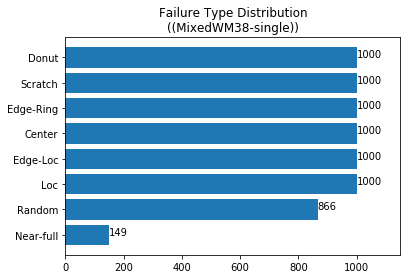

In [5]:
# IF LABELED
# show failure type distribution
if labeled:
    data_defects = data[data.detectLabels == 1]
    helper.defect_distribution(data_defects, note=f'({filename})')

### Data preprocessing

In [6]:
# resize to 52x52
start = time.time()

def preprocess(x):
    y = sk_resize(x, [52,52])
    new_y = img_as_ubyte(y)
    return new_y
    
data['waferMap224'] = data.waferMap.apply(lambda x: preprocess(x))

print("Wall time: {:.2f} seconds".format(time.time() - start))
print("Sanity checks:")
print(f'Map shape: {data.waferMap224[0].shape}')
print(f'Map unique values:{np.unique(data.waferMap224[0])}')

Wall time: 8.58 seconds
Sanity checks:
Map shape: (52, 52)
Map unique values:[0 1 2]


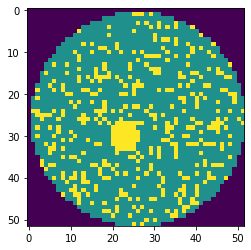

In [8]:
plt.imshow(data.waferMap224[0])

### Classify Model

##### Data set-up

In [9]:
# prepare inputs
start = time.time()

x_cls = np.stack(data['waferMap224'])
x_cls = np.expand_dims(x_cls, axis=-1)

print("Wall time: {:.2f} seconds".format(time.time() - start))
# sanity check
# expected: TensorShape([#rows, xdim, ydim, 1])
x_cls.shape

Wall time: 0.02 seconds


(8015, 52, 52, 1)

In [10]:
# IF LABELED
# prepare labels for evaluating results
if labeled:
    y_cls = np.asarray(data['classifyLabels']).astype(np.uint8)

##### Load and run classify model

In [11]:
# re-build model

inputs=Input(shape=(52, 52, 1))
x = ConvOffset2D_train(1, name='conv_1_offset')(inputs)
x = layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same', name='conv_1')(x)
x = layers.BatchNormalization(axis=3, name='batch_normalization_1')(x)
x = layers.Activation('relu', name='activation_1')(x)

# Conv_2 layer
x = ConvOffset2D_train(32, name='conv_2_offset')(x)
x = layers.Conv2D(32*2, (3, 3), strides=(2, 2), padding='same', name='conv_2')(x)
x = layers.BatchNormalization(axis=3, name='batch_normalization_2')(x)
x = layers.Activation('relu', name='activation_2')(x)

# Conv_3 layer
x = ConvOffset2D_train(64, name='conv_3_offset')(x)
x = layers.Conv2D(32*4, (3, 3), strides=(2, 2), padding='same', name='conv_3')(x)
x = layers.BatchNormalization(axis=3, name='batch_normalization_3')(x)
x = layers.Activation('relu', name='activation_3')(x)

# Conv_4 layer
x = ConvOffset2D_train(128, name='conv_4_offset')(x)
x = layers.Conv2D(32*8, (3, 3), padding='same', name='conv_4')(x)
x = layers.BatchNormalization(axis=3, name='batch_normalization_4')(x)
x = layers.Activation('relu', name='activation_4')(x)

# Conv_5 layer
x = ConvOffset2D_train(256, name='conv_5_offset')(x)
x = layers.Conv2D(32*4, (3, 3), strides=(2, 2), padding='same', name='conv_5')(x)
x = layers.BatchNormalization(axis=3, name='batch_normalization_5')(x)
x = layers.Activation('relu', name='activation_5')(x)

# Pooling layer
x = layers.MaxPooling2D(3)(x)

# fc layer
x = layers.Flatten()(x)
outputs = layers.Dense(9, activation='softmax', name='fc')(x)

classify = Model(inputs=inputs, outputs=outputs)


# load model weights
classify.load_weights(classify_model)

classify.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 52, 52, 1)         0         
_________________________________________________________________
conv_1_offset (ConvOffset2D_ (None, 52, 52, 1)         18        
_________________________________________________________________
conv_1 (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
conv_2_offset (ConvOffset2D_ (None, 26, 26, 32)        18432     
__________________________________________

In [12]:
# generate predictions
start = time.time()

classify_pred = classify.predict(x_cls)
cls_labels = np.argmax(classify_pred, axis=1).astype(np.uint8)

print("Wall time: {:.2f} seconds".format(time.time() - start))


Wall time: 11.17 seconds


### Collect tandem model results
Saved predictions include 2 lists:
- Output of classify model (softmax probabilities)
- Labels predicted by classify model

In [13]:
# # save predictions to local instance
# predictions = [classify_pred, cls_labels]
# with open(f'{result_path}/{result_filename}.pkl', "wb") as f:
#     pickle.dump(predictions, f)

Overall Model Accuracy: 57.40%


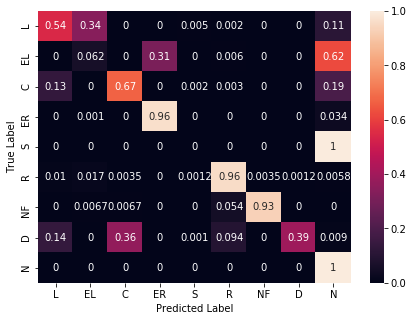

In [14]:
# IF LABELED
if labeled: 
    y_test = data['classifyLabels'].tolist()
    
    # manually compute overall accuracy
    cls_cm = confusion_matrix(y_test, cls_labels)

    cls_num = 0
    for i in range(9):
        cls_num += cls_cm[i][i]

    overall_accuracy = cls_num / len(y_test) * 100
    print(f'Overall Model Accuracy: {overall_accuracy:.2f}%') 

    # plot confusion matrix
    helper.plot_confusion_matrix(y_test, cls_labels, mode='all', normalize=True)

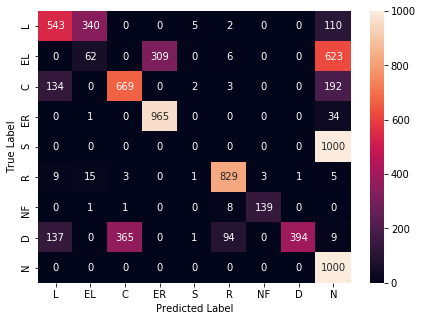

In [15]:
# IF LABELED
# plot confusion matrix counts
if labeled:
    helper.plot_confusion_matrix(y_test, cls_labels, mode='all', normalize=False)